In [1]:
import os
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary

from NN_config import Config
from HD_DataLoader import *
from NN_model import *


Get the database:

In [2]:
folder_path = os.path.join(os.getcwd(), 'HD_data') 
HD_class = HD(data_path = folder_path)
database = HD_class.generate_database()

---------------------------------------------------------
Generating database for HD's


Get the testing, training and validation set:

In [3]:
# Assuming you have a database variable containing your raw data
# dataset = VairableSensorsDataset(database, mic_bool='True', vibr_bool='False', cur_bool='False', speed_bool='False', start_percentage=0.1, stop_percentage = 0.9, window_sec = 0.1, stride_sec=0.03)
# dataset = VairableSensorsDataset(database, mic_bool='True', vibr_bool='False', cur_bool='False', start_percentage=0.1, stop_percentage = 0.9, window_sec = 0.1, stride_sec=0.03)
dataset = StatisticalFeaturesDataset(database, window_sec=2,selected_domain = {'Mic': 'freq','Vibr': 'time', 'dSpace': 'time'})

# Splitting the data into train, test, and validation sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42, shuffle=True)

# Creating data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Setup the NN

In [4]:
train_features, train_labels = next(iter(train_dataloader))
input_dim = train_features.shape[1]
print('The input dimension: ' + str(input_dim))
print('The amound of batches in the train loaders: ' + str(len(train_dataloader)))
      
cfg = Config()

# Initialize network
model = Classifier(input_dim)
model.train()
if cfg.enable_cuda:
    model = model.cuda()

# Initialize optimizer
# optimizer = optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.lr_momentum, weight_decay=cfg.weight_decay)

# class_weights = torch.tensor([1, 0.5]) #because we have twice as
# criterion = nn.BCELoss(weight=class_weights)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

summary(model,input_size=(batch_size,input_dim))

The input dimension: 11
The amound of batches in the train loaders: 13


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [32, 1]                   --
├─Linear: 1-1                            [32, 20]                  240
├─Linear: 1-2                            [32, 40]                  840
├─Linear: 1-3                            [32, 20]                  820
├─Linear: 1-4                            [32, 1]                   21
├─Sigmoid: 1-5                           [32, 1]                   --
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03

Train the NN

In [5]:
# Track losses
train_losses = []
val_losses = []
i = 0

for epoch in range(cfg.num_epochs):
    
    #Training phase
    model.train()  # Set the model in training mode
    epoch_train_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float().reshape(-1,1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        # sample_weights = torch.where(labels == 1, torch.tensor(0.5), torch.tensor(1))
        # weighted_loss = torch.mean(loss * sample_weights)

        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

        # Print training progress
        # if (i + 1) % 10 == 0:
        #     print(f"Epoch [{epoch + 1}/{cfg.num_epochs}], Batch [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Validation phase
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
            for i, data in enumerate(val_dataloader,0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                labels = labels.float().reshape(-1,1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs >= 0.5).squeeze().long()
                total += labels.size(0)
                correct += predicted.eq(labels.squeeze()).sum().item()

    # Print training validation metrics
    val_loss /= len(val_dataloader)
    val_acc = correct / total * 100
    train_loss = epoch_train_loss / len(train_dataloader)

    print(f"Epoch [{epoch + 1}/{cfg.num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

print("Finished training.")
save_path = 'model.pth'
torch.save(model.state_dict(), save_path)
print("Saved trained model as {}.".format(save_path))

Epoch [1/10], Training Loss: 0.6957, Validation Loss: 0.6167, Validation Accuracy: 68.18%
Epoch [2/10], Training Loss: 0.6370, Validation Loss: 0.5971, Validation Accuracy: 68.18%
Epoch [3/10], Training Loss: 0.6198, Validation Loss: 0.5431, Validation Accuracy: 68.18%
Epoch [4/10], Training Loss: 0.5824, Validation Loss: 0.5029, Validation Accuracy: 68.18%
Epoch [5/10], Training Loss: 0.5701, Validation Loss: 0.4394, Validation Accuracy: 68.18%
Epoch [6/10], Training Loss: 0.5843, Validation Loss: 0.4615, Validation Accuracy: 81.82%
Epoch [7/10], Training Loss: 0.5621, Validation Loss: 0.4596, Validation Accuracy: 81.82%
Epoch [8/10], Training Loss: 0.5403, Validation Loss: 0.4220, Validation Accuracy: 68.18%
Epoch [9/10], Training Loss: 0.5141, Validation Loss: 0.4037, Validation Accuracy: 70.45%
Epoch [10/10], Training Loss: 0.5486, Validation Loss: 0.3884, Validation Accuracy: 70.45%
Finished training.
Saved trained model as model.pth.


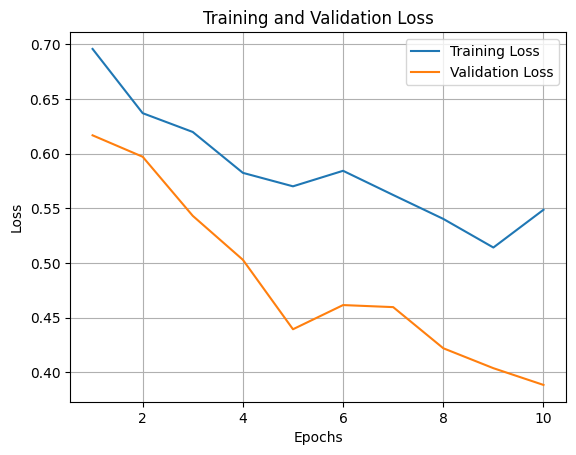

In [6]:
# Plot the losses
plt.plot(range(1, cfg.num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, cfg.num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

Test the model

In [7]:
correct = 0
total = 0
print("Starting evaluation with the test set...")

with torch.no_grad():
    for i, data in enumerate(test_dataloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float().reshape(-1,1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        predicted = (outputs >= 0.5).squeeze().long()
        total += labels.size(0)
        correct += predicted.eq(labels.squeeze()).sum().item()

print("Accuracy of the network on the {} test images: {} %".format(total, round((correct/total*100), 1)) )
print("Correct predictions: {}".format(correct))
print("Total predictions: {}".format(total))

Starting evaluation with the test set...
Accuracy of the network on the 108 test images: 75.9 %
Correct predictions: 82
Total predictions: 108


Hugo his code using different classes in the dataloader

In [8]:
# test = SplitNormalFaulty(database)
# working, faulty = test.split_faulty_working_vib('X_vibr')
# Data_prep = DataPreprocessing(working, faulty)

# inputs, labels = Data_prep.create_data_batches()

# print("Number of inputs is {}".format(len(inputs)))


In [9]:
# x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.4, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# training_data = CustomDataset(x_train, y_train)
# test_data = CustomDataset(x_test, y_test)
# val_data = CustomDataset(x_val, y_val)

# # training_data = CustomImageDataset(x_train, y_train)
# # test_data = CustomImageDataset(x_test, y_test)

# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [10]:
# train_features, train_labels = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")